## Get Cuda and Processor information

In [40]:
import sys
sys.path.append('../Submodular')

import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

NUM_PROCESSORS

40

In [41]:
import multiprocessing

NUM_PROCESSORS=multiprocessing.cpu_count()
print("Cpu count: ",NUM_PROCESSORS)

Cpu count:  40


In [42]:
from ipynb.fs.full.Dataset import get_data,generate_synthetic
from ipynb.fs.full.Dataset import datasets as available_datasets
from ipynb.fs.full.Utils import save_plot

In [43]:
import argparse
from argparse import ArgumentParser

#set default arguments here
def get_configuration():
    parser = ArgumentParser()
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--log_info', type=bool, default=True)
    parser.add_argument('--pbar', type=bool, default=False)
    parser.add_argument('--batch_size', type=int, default=2048)
    parser.add_argument('--learning_rate', type=float, default=0.01)
    parser.add_argument('--recompute', type=bool, default=False)
    parser.add_argument('--num_gpus', type=int, default=-1)
    parser.add_argument('--parallel_mode', type=str, default="dp", choices=['dp', 'ddp', 'ddp2'])
    parser.add_argument('--dataset', type=str, default="Cora", choices=available_datasets)
    parser.add_argument('--use_normalization', action='store_false', default=True)
    parser.add_argument('--f') ##dummy for jupyternotebook
    args = parser.parse_args()
    
    dict_args = vars(args)
    
    return args, dict_args

args, dict_args = get_configuration()

## libraries

In [44]:
import random
import numpy as np
import torch

SYNTHETIC = True
seed = 123

data_filename_extension = ""

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
None

In [45]:
import os
import math
import time
from tqdm import tqdm
import torch.nn as nn
from torch_geometric.data import Data, Dataset

## GNN model

In [46]:
import torch_geometric
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv, ChebConv
from torch_geometric.nn import GraphConv, TransformerConv
from torch_geometric.utils import degree
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
from ipynb.fs.full.SpatialConv import SpatialConv

### GNN option 1

In [47]:
GNNconv = SAGEConv

In [48]:
# from torch_geometric.nn import GCNConv, GATConv, GINConv, SAGEConv
GNNconv2 = GATConv

class GNNother(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=256):
        super().__init__()        
        ##GNN layer
        global GNNconv2
        
        if(GNNconv2==GINConv):
            self.MLP1 = nn.Linear(num_features,hidden_channels)
            self.MLP2 = nn.Linear(hidden_channels,num_classes)
            self.conv1 = GNNconv2(self.MLP1)
            self.conv2 = GNNconv2(self.MLP2)                
        else:        
            self.conv1 = GNNconv2(num_features, hidden_channels)
            self.conv2 = GNNconv2(hidden_channels,num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        
        #x = x.log_softmax(dim=-1)
        #x = x.relu()
        
        return x
    

class GNNGAT(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels, heads, edge_dim=1)  # TODO
        self.conv2 = GATConv(hidden_channels*heads, num_classes, heads=1, concat=True, edge_dim=1)  # TODO

    def forward(self, x, edge_index, edge_attr=None):
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return x

In [49]:
class GNNHomophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = GNNconv(num_features, hidden_channels)
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = GNNconv(hidden_channels,num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class GNNHeterophily(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16):
        super().__init__()
        self.num_classes = num_classes
             
        self.conv1 = ChebConv(num_features, hidden_channels, K=2, normalization='sym')
        #self.conv2 = GNNconv(hidden_channels,hidden_channels)
        self.conv3 = ChebConv(hidden_channels,num_classes, K=2, normalization='sym')

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = x.relu()
#         x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index, edge_weight)
        
        return x
    
class AGSGNN(torch.nn.Module):
    def __init__(self, num_features,num_classes, hidden_channels=16, dropout=0.5):
        super().__init__()
        self.num_classes = num_classes
        
        hidden = int(hidden_channels/2)        
        
        ####################
        self.gnn1 = GNNHomophily(num_features, hidden, hidden_channels)
#         self.gnn2 = GNNHomophily(num_features, hidden, hidden_channels)
        
# #         self.gnn1 = GNNHeterophily(num_features, hidden, hidden_channels)
        self.gnn2 = GNNHeterophily(num_features, hidden, hidden_channels)
        
#         ####################
#         self.gnn1 = GNNother(num_features, hidden, hidden_channels)
#         self.gnn2 = GNNother(num_features, hidden, hidden_channels)        

#         ####################
#         self.gnn1 = GNNHomophily(num_features, num_classes, hidden_channels)
#         self.gnn1 = GNNHeterophily(num_features, num_classes, hidden_channels)
        #################
    
        self.p = dropout
        self.com_lin = nn.Linear(hidden*2, num_classes)
        
        
#         self.T = 2        
#         self.layer_norm_a1 =  nn.LayerNorm(num_classes)
#         self.layer_norm_s1 =  nn.LayerNorm(num_classes)
        
#         self.alpha_a1 = nn.Linear(num_classes, 1)
#         self.alpha_s1 = nn.Linear(num_classes, 1)
#         self.w1 = nn.Linear(self.T, self.T)
        
        #self.reset_parameters()
            
#     def reset_parameters(self):
#         std_att = 1. / math.sqrt(self.w1.weight.size(1))
#         std_att_vec = 1. / math.sqrt( self.alpha_a1.weight.size(1))
        
#         self.alpha_s1.weight.data.uniform_(-std_att, std_att)
#         self.alpha_i1.weight.data.uniform_(-std_att, std_att)
        
#         self.layer_norm_a1.reset_parameters()
#         self.layer_norm_s1.reset_parameters()        
        
    def forward(self, batch_data):
        
        #out = model(batch_data.x, batch_data.edge_index, batch_data.weight)
        #out = model(batch_data.x, batch_data.edge_index, batch_data.edge_weight)
        #out = model(batch_data.x, batch_data.edge_index)
        
        x1 = self.gnn1(batch_data[0].x, batch_data[0].edge_index)
#         return x1        
        
        x2 = self.gnn2(batch_data[1].x, batch_data[1].edge_index)
        #return x2
        
        a1 = F.relu(x1)
        #a1 = self.layer_norm_a1(a1)
        a1 = F.dropout(a1, p=self.p, training=self.training)
        
        s1 = F.relu(x2)
        #s1 = self.layer_norm_s1(s1)
        s1 = F.dropout(s1, p=self.p, training=self.training)
        
        used = batch_data[0].batch_size
        
        x = torch.cat([a1[:used,:], s1[:used,:]], dim=-1)
        x = self.com_lin(x)
        
        
#         ala1 = torch.sigmoid(self.alpha_a1(a1))
#         als1 = torch.sigmoid(self.alpha_s1(s1))        
        
#         alpha1 = F.softmax(self.w1(torch.cat([ala1, als1],dim=-1)/self.T), dim=1)                
#         x = torch.mm(torch.diag(alpha1[:,0]),a1) + torch.mm(torch.diag(alpha1[:,1]),s1)
        
        #print(x.shape)
        
        return x

## GNN Training and Testing

In [50]:
from torch_geometric.loader import NeighborSampler, NeighborLoader
from ipynb.fs.full.AGSNodeSampler import WeightedNeighborLoader

In [51]:
def test(model, loader, mask, name='Train'):    
    if args.log_info:    
        pbar = tqdm(total=sum(mask).item())
        pbar.set_description(f'Evaluating {name}')
    
    model.eval()
    
    total_correct=0
    total_examples=0
    
    sigmoid = nn.Sigmoid()    
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():                  
    
        for i,batch_data in enumerate(loader):
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size
            
            out = model(batch_data)
                   
            out=out[:used,:]
            pred = out.argmax(dim=1)            

            y_true.append(batch_data[0].y[:used].detach().cpu().numpy())
            y_pred.append(pred.detach().cpu().numpy())
            
            if args.log_info:
                pbar.update(used)
              
    if args.log_info:
        pbar.close()
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    #acc = f1_score(y_true, y_pred, average='micro')
                    
    return acc

In [52]:
def train(DATASET_NAME, model, data, epochs=100, train_neighbors=[-1,10], test_neighbors=[-1,10]):
    
    if args.log_info:
        print("Train neighbors: ", train_neighbors)
        print("Test neighbors: ", test_neighbors)
        
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    optimizer = torch.optim.Adam(model.parameters())
    
    if data.y.ndim == 1:
        criterion = torch.nn.CrossEntropyLoss()
    else:
        criterion = torch.nn.BCEWithLogitsLoss()
    
    batch_size=1024         
#     batch_size=512         
    worker = 8
    
    if data.num_nodes>=50000:
        worker = 8
    else:
        worker = min(8,int(sum(data.train_mask)/batch_size))
        
    if args.log_info:
        print("Worker: ", worker)
        
    weight_func=['knn','submodular']; 
#     weight_func=['knn','submodular']; 
#     weight_func=['random', 'random'];  worker = 0;
#     weight_func=['link-nn', 'link-sub'];  worker = 2;
    params={
        'knn':{'metric':'cosine'},
        'submodular':{'metric':'cosine'},
        'link-nn':{'value':'min'},
        'link-sub':{'value':'max'},
        'apricot':{'sub_func':'coverage','metric':'cosine'}
    }    
    
    global data_filename_extension        
#     sampler_dir = DIR+'AGSGNNstruc/'+DATASET_NAME+data_filename_extension
    sampler_dir = DIR+'AGSGNNstrucCorrect/'+DATASET_NAME+data_filename_extension
    
    if args.log_info:
        print(sampler_dir)
    
    
#     if not os.path.exists(sampler_dir):
#         os.makedirs(sampler_dir)
    
    start = time.time()    
#     loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
#                               batch_size=batch_size, shuffle=True, num_workers=worker, drop_last=False, 
#                               weight_func=weight_func, params=params, log=args.log_info,
#                                     directed=True, replace = False,
#                                     save_dir = sampler_dir,recompute = args.recompute)
    
    loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=True, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=True,
                                    directed=True, replace = False,
                                    save_dir = sampler_dir,recompute = args.recompute)

    train_loader = WeightedNeighborLoader(data, input_nodes=data.train_mask,num_neighbors=train_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=worker, drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info,
                                          directed=True, replace = False,
                                          save_dir = sampler_dir,recompute = False)
    
    val_loader = WeightedNeighborLoader(data, input_nodes=data.val_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.val_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params,log=args.log_info, directed=True, replace = False,
                                        save_dir = sampler_dir,recompute = False)
    
    test_loader = WeightedNeighborLoader(data, input_nodes=data.test_mask,num_neighbors=test_neighbors, 
                              batch_size=batch_size, shuffle=False, num_workers=min(8,int(sum(data.test_mask)/batch_size)), drop_last=False, 
                              weight_func=weight_func, params=params, log=args.log_info, directed=True, replace = False,
                                         save_dir = sampler_dir,recompute = False)
    
    top_k_accs = []    
    best_acc=0  
    
    train_losses=[]
    val_accuracies=[]
    train_accuracies=[]
    test_accuracies=[]
    
    num_iteration = epochs
    
    end = time.time()
    if args.log_info:
        print("Total initialization time: ", end-start)
    
    start = time.time()
    
    for epoch in range(1,epochs+1):
        
        if args.log_info:
            pbar = tqdm(total=int(sum(data.train_mask)))
            pbar.set_description(f'Epoch {epoch:02d}')
        
        model.train()
        total_loss = total_examples = 0
        
        for i,batch_data in enumerate(loader):            
            #print(batch_data)
            
            batch_data = [b.to(device) for b in batch_data]
            used = batch_data[0].batch_size #int(sum(batch_data.train_mask))       
            
            optimizer.zero_grad()            
            out = model(batch_data)
            #out = F.log_softmax(out, dim=1)                 
            #loss = F.nll_loss(out[batch_data[0].train_mask], batch_data[0].y[batch_data[0].train_mask])
            #loss = F.cross_entropy(out[:used], batch_data[0].y[:used])
            loss = criterion(out[:used], batch_data[0].y[:used])
            
            loss.backward()
            optimizer.step()
                        
            total_loss += loss.item() * used
            total_examples += used
            
            if args.log_info:
                pbar.update(used)
        if args.log_info:
            pbar.close()
        
        loss=total_loss / total_examples
        train_losses.append(loss)
        
        #print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}', end = ', ')                
        
        if args.log_info:
            train_acc=test(model, train_loader,data.train_mask,'Train')            
            train_accuracies.append(train_acc.item())        
        else:
            train_acc = 0 ; train_accuracies.append(train_acc)
        
        if args.log_info:
            val_acc = test(model, val_loader,data.val_mask,'Validation')
            val_accuracies.append(val_acc.item())
        else:
            val_acc = 0 ; val_accuracies.append(val_acc)
    
        if epoch%10==0:
            test_acc = test(model, test_loader,data.test_mask,'Test')
            test_accuracies.append(test_acc.item())
        else:
            test_acc = 0
            test_accuracies.append(test_acc)
            
        
        #print(f'Epoch: {epoch:03d}, Test: {test_acc:.4f}')
        
        std_dev = np.std(train_losses[-5:])
        #print(f'Epoch: {epoch:03d}, Std dev: {std_dev:.4f}')
        
        if args.log_info:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}, Std dev: {std_dev:.4f}')

        if epoch>=5 and std_dev<=1e-3:
            num_iteration = epoch
            
            if args.log_info:                
                print("Iteration for convergence: ", epoch)
            break
        
    if args.log_info:
        #save_plot([val_accuracies], labels=['Validation'], name='Plots/Validation', yname='Accuracy', xname='Epoch')    
        save_plot([train_losses, train_accuracies, val_accuracies, test_accuracies], labels=['Loss','Train','Validation','Test'], name='Results/AGSNSVal', yname='Accuracy', xname='Epoch')
        
        print ("Best Validation Accuracy, ",max(val_accuracies))
        print ("Best Test Accuracy, ",max(test_accuracies))
        
    best_acc = max(test_accuracies)
    
    end = time.time()
    if args.log_info:
        print("Total epoch time: ", end-start)    
    
    return best_acc, num_iteration

In [53]:
def AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=1, train_neighbors=[-1,-1], test_neighbors=[-1,-1]):        
    
    model = AGSGNN(data.x.shape[1], num_classes, hidden_channels=256).to(device)
    
    if args.log_info: print(model)    
    
    best_acc, num_iteration = train(DATASET_NAME, model, data, epochs, train_neighbors=train_neighbors, test_neighbors=test_neighbors)    
    
    return best_acc, num_iteration, model

In [54]:
def adj_feature(data):    
    adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
    edges = data.edge_index.t()
    adj_mat[edges[:,0], edges[:,1]] = 1
    return adj_mat

# adj_feature(data)
# data.x.shape

In [55]:
from torch_geometric.utils import add_self_loops

# AGS-GNN Running

N  183  E  325  d  1.7759562841530054 0.06539812684059143 0.10769230872392654 0.0 -0.34627223014831543 
Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183], val_mask=[183], test_mask=[183])
AGSGNN(
  (gnn1): GNNHomophily(
    (conv1): SAGEConv(1703, 256)
    (conv3): SAGEConv(256, 128)
  )
  (gnn2): GNNHeterophily(
    (conv1): ChebConv(1703, 256, K=2, normalization=sym)
    (conv3): ChebConv(256, 128, K=2, normalization=sym)
  )
  (com_lin): Linear(in_features=256, out_features=5, bias=True)
)
Train neighbors:  [8, 4]
Test neighbors:  [8, 4]
Worker:  0
./Dataset/AGSGNNstrucCorrect/Texas
Loading weights  knncosine
Loading weights  submodular
Total initialization time:  0.005717039108276367


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 645.25it/s]


Epoch: 001, Train Loss: 1.6207, Train: 0.7011, Val: 0.4068, Test: 0.0000, Std dev: 0.0000


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 744.21it/s]


Epoch: 002, Train Loss: 1.4539, Train: 0.8161, Val: 0.5763, Test: 0.0000, Std dev: 0.0834


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 850.80it/s]


Epoch: 003, Train Loss: 1.2858, Train: 0.8161, Val: 0.6102, Test: 0.0000, Std dev: 0.1367


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 857.44it/s]


Epoch: 004, Train Loss: 1.1484, Train: 0.8276, Val: 0.6441, Test: 0.0000, Std dev: 0.1774


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 859.60it/s]


Epoch: 005, Train Loss: 0.9543, Train: 0.8276, Val: 0.6102, Test: 0.0000, Std dev: 0.2319


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 832.16it/s]


Epoch: 006, Train Loss: 0.8237, Train: 0.8161, Val: 0.6441, Test: 0.0000, Std dev: 0.2255


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 833.86it/s]


Epoch: 007, Train Loss: 0.7199, Train: 0.8161, Val: 0.6271, Test: 0.0000, Std dev: 0.2071


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 849.29it/s]


Epoch: 008, Train Loss: 0.6517, Train: 0.8391, Val: 0.6610, Test: 0.0000, Std dev: 0.1769


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 850.93it/s]


Epoch: 009, Train Loss: 0.5151, Train: 0.8391, Val: 0.7119, Test: 0.0000, Std dev: 0.1493


Evaluating Test: 100%|██████████| 37/37 [00:00<00:00, 925.08it/s]


Epoch: 010, Train Loss: 0.4692, Train: 0.8506, Val: 0.7119, Test: 0.6486, Std dev: 0.1303


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 848.48it/s]


Epoch: 011, Train Loss: 0.3877, Train: 0.8851, Val: 0.7288, Test: 0.0000, Std dev: 0.1211


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 811.35it/s]


Epoch: 012, Train Loss: 0.3347, Train: 0.8851, Val: 0.7288, Test: 0.0000, Std dev: 0.1096


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 864.09it/s]


Epoch: 013, Train Loss: 0.3122, Train: 0.8851, Val: 0.7288, Test: 0.0000, Std dev: 0.0776


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 861.64it/s]


Epoch: 014, Train Loss: 0.2499, Train: 0.9080, Val: 0.7288, Test: 0.0000, Std dev: 0.0739


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 858.26it/s]


Epoch: 015, Train Loss: 0.2251, Train: 0.9195, Val: 0.7288, Test: 0.0000, Std dev: 0.0586


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 864.16it/s]


Epoch: 016, Train Loss: 0.1960, Train: 0.9540, Val: 0.7288, Test: 0.0000, Std dev: 0.0522


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 853.86it/s]


Epoch: 017, Train Loss: 0.1653, Train: 0.9655, Val: 0.7458, Test: 0.0000, Std dev: 0.0500


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 861.66it/s]


Epoch: 018, Train Loss: 0.1365, Train: 0.9885, Val: 0.7458, Test: 0.0000, Std dev: 0.0406


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 862.47it/s]


Epoch: 019, Train Loss: 0.1137, Train: 0.9885, Val: 0.7797, Test: 0.0000, Std dev: 0.0400


Evaluating Test: 100%|██████████| 37/37 [00:00<00:00, 931.78it/s]


Epoch: 020, Train Loss: 0.0932, Train: 0.9885, Val: 0.7966, Test: 0.7838, Std dev: 0.0365


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 859.34it/s]


Epoch: 021, Train Loss: 0.0750, Train: 0.9885, Val: 0.8136, Test: 0.0000, Std dev: 0.0318


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 854.22it/s]


Epoch: 022, Train Loss: 0.0787, Train: 0.9885, Val: 0.8475, Test: 0.0000, Std dev: 0.0230


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 859.62it/s]


Epoch: 023, Train Loss: 0.0758, Train: 0.9885, Val: 0.8644, Test: 0.0000, Std dev: 0.0147


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 865.13it/s]


Epoch: 024, Train Loss: 0.0562, Train: 0.9885, Val: 0.8475, Test: 0.0000, Std dev: 0.0118


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 859.71it/s]


Epoch: 025, Train Loss: 0.0397, Train: 0.9885, Val: 0.8475, Test: 0.0000, Std dev: 0.0150


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 863.82it/s]


Epoch: 026, Train Loss: 0.0398, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0168


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 861.89it/s]


Epoch: 027, Train Loss: 0.0328, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0155


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 863.21it/s]


Epoch: 028, Train Loss: 0.0318, Train: 1.0000, Val: 0.8475, Test: 0.0000, Std dev: 0.0087


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 864.89it/s]


Epoch: 029, Train Loss: 0.0239, Train: 1.0000, Val: 0.8475, Test: 0.0000, Std dev: 0.0059


Evaluating Test: 100%|██████████| 37/37 [00:00<00:00, 934.86it/s]


Epoch: 030, Train Loss: 0.0224, Train: 1.0000, Val: 0.8305, Test: 0.8108, Std dev: 0.0064


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 866.58it/s]


Epoch: 031, Train Loss: 0.0236, Train: 1.0000, Val: 0.8475, Test: 0.0000, Std dev: 0.0045


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 858.52it/s]


Epoch: 032, Train Loss: 0.0198, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0040


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 856.65it/s]


Epoch: 033, Train Loss: 0.0211, Train: 1.0000, Val: 0.7966, Test: 0.0000, Std dev: 0.0015


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 853.72it/s]


Epoch: 034, Train Loss: 0.0199, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0014


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 860.32it/s]


Epoch: 035, Train Loss: 0.0167, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0022


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 866.60it/s]


Epoch: 036, Train Loss: 0.0168, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0018


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 864.13it/s]


Epoch: 037, Train Loss: 0.0088, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0043


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 867.17it/s]


Epoch: 038, Train Loss: 0.0128, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0039


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 857.51it/s]


Epoch: 039, Train Loss: 0.0069, Train: 1.0000, Val: 0.8136, Test: 0.0000, Std dev: 0.0040


Evaluating Test: 100%|██████████| 37/37 [00:00<00:00, 932.06it/s]


Epoch: 040, Train Loss: 0.0110, Train: 1.0000, Val: 0.8136, Test: 0.8378, Std dev: 0.0034


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 866.81it/s]


Epoch: 041, Train Loss: 0.0073, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0022


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 863.71it/s]


Epoch: 042, Train Loss: 0.0078, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0023


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 862.94it/s]


Epoch: 043, Train Loss: 0.0070, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0015


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 859.13it/s]


Epoch: 044, Train Loss: 0.0064, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0016


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 855.47it/s]


Epoch: 045, Train Loss: 0.0048, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0010


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 865.82it/s]


Epoch: 046, Train Loss: 0.0059, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0010


Evaluating Validation: 100%|██████████| 59/59 [00:00<00:00, 860.44it/s]


Epoch: 047, Train Loss: 0.0076, Train: 1.0000, Val: 0.8305, Test: 0.0000, Std dev: 0.0009
Iteration for convergence:  47


<Figure size 640x480 with 0 Axes>

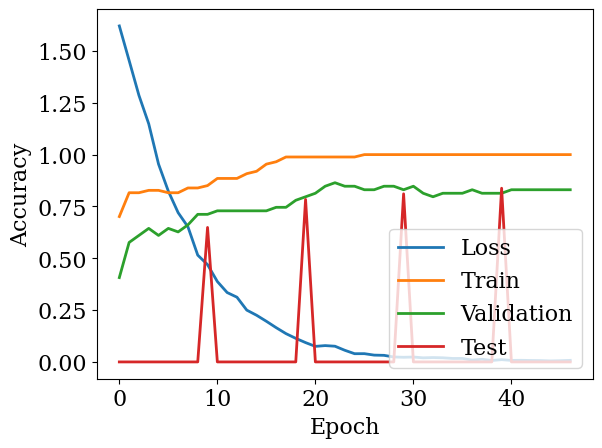

Best Validation Accuracy,  0.864406779661017
Best Test Accuracy,  0.8378378378378378
Total epoch time:  12.66198992729187
0.8378378378378378 47


In [56]:
args.log_info = True
DATASET_NAME = 'Texas'
data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=True, split_no=1); print("")
print(data)

# (row, col) = data.edge_index
# data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
# data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
# print(data)

args.recompute = False


if len(data.y.shape) > 1:
    data.y = data.y.argmax(dim=1)        
    num_classes = torch.max(data.y).item()+1
else:
    num_classes = dataset.num_classes

if num_classes!= torch.max(data.y)+1:
    num_classes = torch.max(data.y).item()+1
    
# data.edge_index, _ = add_self_loops(data.edge_index)            
# data.x = torch.cat((data.x, adj_feature(data)), dim=1)
# if args.log_info == True:
#     print(data.x.shape)

    
# if DATASET_NAME in ['Cornell', 'cornell5']:
#     data.edge_index, _ = add_self_loops(data.edge_index)            
    
# if DATASET_NAME in ['Squirrel', 'Chameleon', 'amherst41',
#                     'Cornell','cornell5', 'johnshopkins55']:
#     data.x = torch.cat((data.x, adj_feature(data)), dim=1)
#     if args.log_info == True:
#         print(data.x.shape)


best_acc, num_iteration, _ =  AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=150, train_neighbors=[8,4], test_neighbors=[8,4])
print(best_acc, num_iteration)

# Batch Experiments

In [57]:
def batch_experiments(num_run=1):
    
    ALL_DATASETs= [
        "Cornell","Texas","Wisconsin",
        "reed98","amherst41",
        "penn94","Roman-empire","cornell5","Squirrel","johnshopkins55",
        "AmazonProducts",
        "Actor","Minesweeper","Questions","Chameleon",
        "Tolokers","Flickr",
        "Yelp","Amazon-ratings","genius","cora","CiteSeer",
        "dblp","Computers","PubMed","pubmed","Reddit",
        "cora_ml","Cora","Reddit2","CS","Photo","Physics","citeseer"
    ]     
    
    ALL_DATASETs= [
        'karate',
    ]

    args.log_info = False
    
    filename = "Results/AGSGNN-NS-2.txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        print(DATASET_NAME, end=' ')
        
        
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)   
            
            #optional for making undirected graph
            (row, col) = data.edge_index
            data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
            data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
            
#             if data.num_nodes>100000:
#                 accs.append(-1)
#                 itrs.append(-1)
#                 break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 150
            else:
                max_epochs = 20
                
            if DATASET_NAME in ['Squirrel', 'Chameleon','cornell5','penn94','johnshopkins55'
                               "amherst41"]:
                data.x = torch.cat((data.x, adj_feature(data)), dim=1)
                if args.log_info == True:
                    print(data.x.shape)
                              
            accuracy, itr, _ = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[8,4], test_neighbors=[8,4])
            
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        #print(accs, itrs)
        print(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs):0.4f} sd {np.std(accs):0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                
batch_experiments(num_run=5)

karate Loading weights  knncosine
Loading weights  submodular
Loading weights  knncosine
Loading weights  submodular
Loading weights  knncosine
Loading weights  submodular
Loading weights  knncosine
Loading weights  submodular
Loading weights  knncosine
Loading weights  submodular
acc 0.6067 sd 0.0646 itr 95 sd 8


## View Learned Representation

In [58]:
if __name__ == '__main__':    
    
    n=7
    x = torch.Tensor([[1,0],[1,0],[1,0],[0,1],[0,1],[0,1],[0,1]])
    y = torch.LongTensor([0,0,0, 1, 1, 1, 1])
    edge_index = torch.LongTensor([[1,2],[1,4],[1,5],[2,1],[3,6],[3,7],[4,5],[4,1],[4,6],[4,7],[5,1],[5,4],[5,6],[6,3],[6,4],[6,5],[6,7],[7,3],[7,4],[7,6]]).T
    edge_index = edge_index-1
    
    mask = torch.zeros(n, dtype=torch.bool)
    mask[[1,3]] = True
    
    test_data = Data(x = x, y = y, edge_index = edge_index, train_mask = mask, test_mask = mask, val_mask = mask)    
    print(test_data)
    
    
    None

Data(x=[7, 2], edge_index=[2, 20], y=[7], train_mask=[7], test_mask=[7], val_mask=[7])


In [59]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [60]:
# model.eval()
# #X = model(data.x.to(device),data.edge_index.to(device), data.weight.to(device))
# X = model(data.x.to(device),data.edge_index.to(device))
# X = X.detach().to('cpu')
# y = data.y.to('cpu')
# X.shape

In [61]:
# plt.figure(figsize=(10, 10))

# # Create a t-SNE model with 2 components and a perplexity of 30
# tsne = TSNE(n_components=2, perplexity=30, random_state=42, learning_rate='auto', init='random')

# # Fit and transform the data to the 2D t-SNE space
# X_tsne = tsne.fit_transform(X)

# # Plot the data in the 2D t-SNE space, colored by class
# plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y)
# plt.show()

In [62]:
## Sparsify

In [63]:
from ipynb.fs.full.SubmodularWeights import SubModularWeightFacilityFaster
from ipynb.fs.full.KNNWeights import KNNWeight
# from ipynb.fs.full.PretrainedLink import LinkPred, LinkNN, LinkSub
from ipynb.fs.full.PretrainedLinkFast import get_link_weight, LinkNN, LinkSub
from ipynb.fs.full.RandomSparse import RandomSparse
import torch_geometric.utils.homophily as homophily
import copy
import networkx as nx
from torch_geometric.utils import to_networkx, from_networkx

In [64]:
def sparsify(data, log = True, method = 'NN', metric= None):
    data.to('cpu')    
    
    if metric is None:
        metric = 'cosine'
    
    if method == 'nn':
        submodular_weight = KNNWeight(data, metric=metric, log=log)                
        data.weight = submodular_weight.compute_weights()        

    elif method == 'submodular':
        submodular_weight = SubModularWeightFacilityFaster(data, metric=metric, log=log)
        data.weight = submodular_weight.compute_weights()        
    
    elif method == 'link-nn':    
        submodular_weight = LinkPred(data, selfloop = True, log=log)
        data.weight = submodular_weight.compute_weights()        
        nn_weight = LinkNN(data, value='min', log=log) #min favor similar ones, max disimilar
        data.weight = nn_weight.compute_weights()
    elif method == 'link-sub':    
        nn_weight = LinkSub(data, value='max', selfloop = True, log=log) #min favor similar ones, max disimilar    
        data.weight = nn_weight.compute_weights()
    else:
        raise 'Not implemented error'
    
    cp_data= copy.deepcopy(data)
    G = to_networkx(cp_data, to_undirected=False, edge_attrs=['weight'])
    to_remove = [(a,b) for a, b, attrs in G.edges(data=True) if attrs["weight"] < 0.7 ]
    G.remove_edges_from(to_remove)
    updated_data = from_networkx(G)
    
    updated_data = from_networkx(G, group_edge_attrs=['weight'])
    updated_data.weight = updated_data.edge_attr.view(-1)

    row, col = updated_data.edge_index
    updated_data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    updated_data.weight = torch.cat((updated_data.weight, updated_data.weight),dim=0)

    
    #if args.log_info:
    if True:
        print(updated_data)
        print("Node Homophily:", homophily(updated_data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(updated_data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(updated_data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", updated_data.num_edges / updated_data.num_nodes)

    data.edge_index = updated_data.edge_index
    data.edge_weight = updated_data.weight
    data.weight = None

    return data

# LOG_INFO = True
# data = sparsify(data, log = False)
# data

In [65]:
def random_sparsify(data, K, log = False):    
    rand_sparse = RandomSparse(data, K = K, log = log)
    edge_index = rand_sparse.sparse()
    row, col = edge_index
    data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    
    if log:
        print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", data.num_edges / data.num_nodes)
    
    return data

In [66]:
def modify_homophily(data, h = 0.1, d = 11, log = False):
    data.to('cpu')
    N = data.num_nodes
    E = data.num_edges
    adj = SparseTensor(
        row=data.edge_index[0], col=data.edge_index[1],
        value=torch.arange(E, device=data.edge_index.device),
        sparse_sizes=(N, N))
    
    edge_index=[]
    
#     h = 0.1
#     d = 11

    match = int(round(d*h))
    unmatch = int(round(d*(1-h)))
    #print(match,unmatch)
    
    for u in range(N):                
        row, col, e_index = adj[u,:].coo()   
        
        cur_y = data.y[u]
        neighbors = data.y[col]
        #print(cur_y, neighbors)
        
        match_indexs = torch.nonzero(neighbors == cur_y).squeeze()
        other_indexs = torch.nonzero(neighbors != cur_y).squeeze()
        
        #print(match_indexs, other_indexs)
        
        if match_indexs.dim()>0:
            m_sel = match_indexs[np.random.choice(len(match_indexs), size=min(match,len(match_indexs)), replace = False)]
        else:
            m_sel = torch.LongTensor([])
        if other_indexs.dim()>0:
            um_sel = other_indexs[np.random.choice(len(other_indexs), size=min(unmatch, len(other_indexs)), replace = False)]
        else:
            um_sel = torch.LongTensor([])
            
        
        #print(m_sel, um_sel)
        
        indexs = torch.cat((m_sel,um_sel),dim=0)
    
        e_index = e_index[indexs]            
        edge_index.extend(e_index)
        
        #break        
            
    edge_index = data.edge_index[:,edge_index]
    row, col = edge_index
    data.edge_index = torch.stack((torch.cat((row, col),dim=0), torch.cat((col, row),dim=0)),dim=0)
    
    if log:
        print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
        print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
        print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    
        print("Degree: ", data.num_edges / data.num_nodes)
    
    return data

# data = modify_homophily(data, h=0.15, d=11, log = True)
# data

In [67]:
def test_hetero():
    d = 42
    for h in np.array(range(0,21))/20:
        DATASET_NAME = 'squirrel'
        data, dataset = get_data(DATASET_NAME, log=False)
        data = generate_synthetic(data, d=d, h = h, train=0.6, random_state=1, log=False, balance = False)
        num_classes = dataset.num_classes
        
        print('d ', d, ' h', h, end=' ')
        count, score = test_uniformity(data, num_classes, log=False)
        print(count, score, end = ' ')
        total_en, en_score = total_entropy(data, num_classes, log=False)
        print(total_en, en_score, end = ' ')
        
        print('sparse', end = ' ')
        data = sparsify(data, log=False)
        
        count, score = test_uniformity(data, num_classes, log=False)
        print(count, score, end = ' ')
        total_en, en_score = total_entropy(data, num_classes, log=False)
        print(total_en, en_score, end = ' ')
        
        print("Nh ", homophily(data.edge_index, data.y, method='node'), end = ' ')
        print("Eh ", homophily(data.edge_index, data.y, method='edge'), end = ' ')
        print("EiH ", homophily(data.edge_index, data.y, method='edge_insensitive'), end = ' ')    
        
#         print("Ha ", agg_homophily(data, 'affinity'), end = ' ')
#         print("Hl ", agg_homophily(data, 'laplacian'), end =' ')
        
        print("D ", data.num_edges / data.num_nodes, end = '\n')


# LOG_INFO = False
# test_hetero()

# Ablation studies

In [68]:
from ipynb.fs.full.Dataset import generate_synthetic2homophily

In [68]:
def ablation(num_run = 1):
    
    #SYN_NAME = random.randint(0,1000)

#     ALL_DATASETs= [
#         'Wisconsin',
#         'reed98',        
#         'Roman-empire',
#         'Actor',
#         'Minesweeper',        
#         'Tolokers'
#     ]

    ALL_DATASETs= [
        "reed98",
        "amherst41",
#         "penn94",
        "cornell5",
        "Squirrel",
        "johnshopkins55",
        "Chameleon",
#         "Tolokers",
#         "Flickr",
        
#         "Computers",
#         "Photo",
#         "Physics",
        
#         "AmazonProducts",
#         "Yelp",
#         'pokec',
#         'twitch-gamer',
#         'wiki',        
        
#         "Reddit",
#         "Reddit2",
    ]
    

    
#     ALL_DATASETs= ["Cora"]
    
    args.log_info = False    
    
    filename = "Results/AGSGNN-NS-2Ablation.txt"
    
    for DATASET_NAME in ALL_DATASETs:  
        
        random_state = 10
        #args.recompute = True
        
        print(DATASET_NAME,"-",random_state, end=' ')
        
        
        result_file = open(filename,'a+')        
        result_file.write(f'{DATASET_NAME} ')
        result_file.close()
                
        accs = []
        itrs = []
                
        for i in range(num_run):
            data, dataset = get_data(DATASET_NAME, DIR=None, log=False, h_score=False, split_no=i)   
            
            d = 100
            h =0.50
            train=0.1
            balance=True
            h2 = 0.25
            ratio = 0.50
                                    
#             global data_filename_extension
#             data_filename_extension = str(d)+str(h)+str(train)+str(random_state)+str(balance)+'.weight'            
#             data_filename = DIR+'AGSGNNstruc/'+DATASET_NAME+str(d)+str(h)+str(train)+str(random_state)+str(balance)
            
#             if os.path.exists(data_filename):
#                 data = torch.load(data_filename)                
#                 print("loaded "+data_filename)
#             else:
#                 data = generate_synthetic(data, d=d, h=h, train=train, random_state=random_state, log=False, balance=balance)
# #                 data = generate_synthetic(data, d=d, h=h, train=train, random_state=random_state, log=False)
#                 torch.save(data,data_filename)
#                 print("saved "+data_filename)
        
#             global data_filename_extension
#             data_filename_extension = str(d)+str(h)+str(h2)+str(ratio)+str(train)+str(random_state)+str(balance)+'.weight'            
#             data_filename = DIR+'AGSGNNstruc/'+DATASET_NAME+str(d)+str(h)+str(h2)+str(ratio)+str(train)+str(random_state)+str(balance)
            
#             if os.path.exists(data_filename):
#                 data = torch.load(data_filename)                
#                 print("loaded "+data_filename)
#             else:
#                 data = generate_synthetic2homophily(data, d=d, h1=h, h2=h2, ratio=ratio, train=train, random_state=random_state, log=False, balance=balance)                 
#                 torch.save(data,data_filename)
#                 print("saved "+data_filename)
    
            ##Sparsifiy
            #data = random_sparsify(data, 13, log = True)
#             data = sparsify(data, log = True, method = 'submodular', metric= 'cosine')
                        
#             data1 = sparsify(copy.deepcopy(data), log = True, method = 'submodular', metric= 'cosine')
#             data = sparsify(data, log = True, method = 'nn', metric= 'cosine')                         
#             data.edge_index = torch.cat((data.edge_index, data1.edge_index), dim=1)
            
            #optional for making undirected graph
            (row, col) = data.edge_index
            data.edge_index = torch.stack((torch.cat((row, col),dim=0),torch.cat((col, row),dim=0)),dim=0)
            data.edge_index = torch_geometric.utils.coalesce(data.edge_index)
            
            if args.log_info:
                print("Node Homophily:", homophily(data.edge_index, data.y, method='node'))
                print("Edge Homophily:", homophily(data.edge_index, data.y, method='edge'))
                print("Edge_insensitive Homophily:", homophily(data.edge_index, data.y, method='edge_insensitive'))    
                print("Degree: ", data.num_edges / data.num_nodes)

            
#             if data.num_nodes>100000:
#                 accs.append(-1)
#                 itrs.append(-1)
#                 break
            
            if len(data.y.shape) > 1:
                data.y = data.y.argmax(dim=1)        
                num_classes = torch.max(data.y).item()+1
            else:
                num_classes = dataset.num_classes
            
            if num_classes!= torch.max(data.y)+1:
                num_classes = torch.max(data.y).item()+1
                
            if data.num_nodes<100000:
                max_epochs = 500
            else:
                max_epochs = 20
                
            if DATASET_NAME in ['Squirrel', 'Chameleon','cornell5','penn94','johnshopkins55','amherst41']:
                data.x = torch.cat((data.x, adj_feature(data)), dim=1)
                if args.log_info == True:
                    print(data.x.shape)

#             accuracy, itr = 0,0
            
#             accuracy, itr, mdl = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[25,25], test_neighbors=[25,25])        
            accuracy, itr, mdl = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[8,4], test_neighbors=[8,4])            
#             accuracy, itr, mdl = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[4,4], test_neighbors=[4,4])            
#             accuracy, itr, mdl = AGSNSperformanceSampler(DATASET_NAME, data, dataset, num_classes, epochs=max_epochs, train_neighbors=[-1,-1], test_neighbors=[-1,-1])
            
            #print(mdl)
            #args.recompute = False
    
            accs.append(accuracy)
            itrs.append(itr)
            #print(itr, accuracy)
                        
        print(accs, itrs)
        print(DATASET_NAME,"-",random_state, end=' ')
        print(f'acc {np.mean(accs)*100:0.4f} sd {np.std(accs)*100:0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}')
        result_file = open(filename,'a+')
        result_file.write(f'acc {np.mean(accs)*100:0.4f} sd {np.std(accs)*10:0.4f} itr {int(np.mean(itrs)):d} sd {int(np.std(itrs)):d}\n')
        result_file.close()
                
    return 

# st_time = time.time()
# ablation(num_run=3)
# en_time = time.time()

# print("Runtime: ", en_time-st_time)

KeyboardInterrupt: 